# Homework 2 (Total 30 points)

Remember -> submission using itslearning *deadline on 09.11.2025*

## Task 1 (15 points)
##### Dataset: Glass Identification 
* Number of records: 214
* Number of features: 9 + 1 (target feature)
* Repository URL: https://archive.ics.uci.edu/dataset/42/glass+identification
 
##### Problems:
a. Find the best two models by creating a complete pipeline per each model, that explores both models and parameters. Comment and compare the results.\
b. Benchmark the best two models in __a.__ by different cross-validation techniques (at least 3). Comment results.\
c. Run one AutoML calculation on the dataset. How do these results compare with the obtained in __a.__? 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split, GridSearchCV, 
    KFold, StratifiedKFold, RepeatedStratifiedKFold,
    cross_val_score, cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! pip install ucimlrepo

In [7]:
from ucimlrepo import fetch_ucirepo

glass_identification = fetch_ucirepo(id=42) 
X = glass_identification.data.features 
y = glass_identification.data.targets

y = y.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# PART A: BEST TWO MODELS

# Model 1: Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid_search = GridSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
rf_grid_search.fit(X_train, y_train)

rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\nTest Set Performance:")
print(f"Accuracy: {rf_test_accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

feature_importance_rf = rf_best_model.named_steps['rf'].feature_importances_
feature_names = X_train.columns

feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_rf
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance (Top 5):")
print(feature_importance_df_rf.head())

# Model 2: Gradient Boosting
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.05, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5],
    'gb__subsample': [0.8, 1.0]
}

print("\nPerforming GridSearchCV...")
gb_grid_search = GridSearchCV(
    gb_pipeline, 
    gb_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
gb_grid_search.fit(X_train, y_train)


gb_best_model = gb_grid_search.best_estimator_
y_pred_gb = gb_best_model.predict(X_test)
gb_test_acc = accuracy_score(y_test, y_pred_gb)

print(f"   Best params: {gb_grid_search.best_params_}")
print(f"   CV accuracy: {gb_grid_search.best_score_:.4f}")
print(f"   Test accuracy: {gb_test_acc:.4f}")

# Feature importance
feature_importance_gb = gb_best_model.named_steps['gb'].feature_importances_
feature_importance_df_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_gb
}).sort_values('Importance', ascending=False)

comparison_a = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'CV Accuracy': [rf_grid_search.best_score_, gb_grid_search.best_score_],
    'Test Accuracy': [rf_test_accuracy, gb_test_acc],
    'CV-Test Gap': [rf_grid_search.best_score_ - rf_test_accuracy,
                    gb_grid_search.best_score_ - gb_test_acc]
})

winner_a = "Random Forest" if rf_test_accuracy > gb_test_acc else "Gradient Boosting"

print(f"\n✓ WINNER: {winner_a}")
print(f"  Test Accuracy: {max(rf_test_accuracy, gb_test_acc):.4f}")

print("\nCOMMENTS:")
print(f"• Random Forest: {rf_test_accuracy:.2%} test accuracy")
print(f"• Gradient Boosting: {gb_test_acc:.2%} test accuracy")
print(f"• Difference: {abs(rf_test_accuracy - gb_test_acc):.2%}")

# Check feature agreement
top_rf = set(feature_importance_df_rf.head(3)['Feature'].values)
top_gb = set(feature_importance_df_gb.head(3)['Feature'].values)
common = top_rf.intersection(top_gb)
print(f"• Common top features: {common if common else 'None'}")

## **Test Set Performance**
**Accuracy:** `0.8372`

---

### **Classification Report**
| Class | Precision | Recall | F1-Score | Support |
|:------|:----------:|:------:|:---------:|:--------:|
| 1 | 0.76 | 0.93 | 0.84 | 14 |
| 2 | 0.85 | 0.73 | 0.79 | 15 |
| 3 | 1.00 | 0.67 | 0.80 | 3 |
| 5 | 1.00 | 0.67 | 0.80 | 3 |
| 6 | 0.67 | 1.00 | 0.80 | 2 |
| 7 | 1.00 | 1.00 | 1.00 | 6 |
| **Accuracy** |  |  | **0.84** | **43** |
| **Macro Avg** | **0.88** | **0.83** | **0.84** | **43** |
| **Weighted Avg** | **0.85** | **0.84** | **0.84** | **43** |

---

### **Confusion Matrix**

[[13  1  0  0  0  0]
 [ 3 11  0  0  1  0]
 [ 1  0  2  0  0  0]
 [ 0  1  0  2  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  0  6]]


---

### **Feature Importance (Top 5)**
| Rank | Feature | Importance |
|:----:|:---------|-----------:|
| 1 | Mg | 0.170773 |
| 2 | Al | 0.156831 |
| 3 | Ca | 0.128801 |
| 4 | RI | 0.126664 |
| 5 | Na | 0.106971 |

---

## **GridSearchCV Results**


CV Accuracy: 0.7373
Test Accuracy: 0.8605


✅ **WINNER: Gradient Boosting**
> **Test Accuracy:** `0.8605`

---

## **COMMENTS**
- **Random Forest:** 83.72% test accuracy  
- **Gradient Boosting:** 86.05% test accuracy  
- **Difference:** +2.33%  
- **Common top features:** `{ 'Al', 'Ca' }`


In [19]:
# PART B

cv_strategies = {
    '1. K-Fold (5 folds)': KFold(n_splits=5, shuffle=True, random_state=42),
    '2. Stratified K-Fold (5 folds)': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    '3. Stratified K-Fold (10 folds)': StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    '4. Repeated Stratified K-Fold (5x2)': RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),
}

cv_results = {
    'CV Strategy': [],
    'Model': [],
    'Mean Accuracy': [],
    'Std Accuracy': [],
    'Min Accuracy': [],
    'Max Accuracy': []
}

for cv_name, cv_strategy in cv_strategies.items():
    # Random Forest
    rf_scores = cross_val_score(
        rf_best_model, X_train, y_train, 
        cv=cv_strategy, scoring='accuracy', n_jobs=-1
    )
    
    cv_results['CV Strategy'].append(cv_name)
    cv_results['Model'].append('Random Forest')
    cv_results['Mean Accuracy'].append(rf_scores.mean())
    cv_results['Std Accuracy'].append(rf_scores.std())
    cv_results['Min Accuracy'].append(rf_scores.min())
    cv_results['Max Accuracy'].append(rf_scores.max())

    # Gradient Boosting
    gb_scores = cross_val_score(
        gb_best_model, X_train, y_train,
        cv=cv_strategy, scoring='accuracy', n_jobs=-1
    )
    
    cv_results['CV Strategy'].append(cv_name)
    cv_results['Model'].append('Gradient Boosting')
    cv_results['Mean Accuracy'].append(gb_scores.mean())
    cv_results['Std Accuracy'].append(gb_scores.std())
    cv_results['Min Accuracy'].append(gb_scores.min())
    cv_results['Max Accuracy'].append(gb_scores.max())
    
cv_results_df = pd.DataFrame(cv_results)

# Analysis

kfold_rf = cv_results_df[(cv_results_df['CV Strategy'] == '1. K-Fold (5 folds)') & 
                          (cv_results_df['Model'] == 'Random Forest')]['Mean Accuracy'].values[0]
strat_rf = cv_results_df[(cv_results_df['CV Strategy'] == '2. Stratified K-Fold (5 folds)') & 
                          (cv_results_df['Model'] == 'Random Forest')]['Mean Accuracy'].values[0]

# Random Forest:
strat5_rf = cv_results_df[(cv_results_df['CV Strategy'] == '2. Stratified K-Fold (5 folds)') & 
                           (cv_results_df['Model'] == 'Random Forest')]['Mean Accuracy'].values[0]
strat10_rf = cv_results_df[(cv_results_df['CV Strategy'] == '3. Stratified K-Fold (10 folds)') & 
                            (cv_results_df['Model'] == 'Random Forest')]['Mean Accuracy'].values[0]
rf_mean = cv_results_df[cv_results_df['Model'] == 'Random Forest']['Mean Accuracy'].mean()

# Gradient Boosting
gb_mean = cv_results_df[cv_results_df['Model'] == 'Gradient Boosting']['Mean Accuracy'].mean()
rf_std = cv_results_df[cv_results_df['Model'] == 'Random Forest']['Std Accuracy'].mean()
gb_std = cv_results_df[cv_results_df['Model'] == 'Gradient Boosting']['Std Accuracy'].mean()

winner_cv = "Random Forest" if rf_mean > gb_mean else "Gradient Boosting"

## **Benchmarking Both Models with Different CV Strategies**

---

### **1️⃣ K-Fold (5 folds)**
| Model | Mean | Std (+/-) | Range |
|:------|:------:|:----------:|:----------------:|
| Random Forest | 0.7607 | 0.0710 | [0.6765, 0.8529] |
| Gradient Boosting | 0.7607 | 0.0659 | [0.6765, 0.8235] |

---

### **2️⃣ Stratified K-Fold (5 folds)**
| Model | Mean | Std (+/-) | Range |
|:------|:------:|:----------:|:----------------:|
| Random Forest | 0.7477 | 0.0875 | [0.6176, 0.8857] |
| Gradient Boosting | 0.7074 | 0.0502 | [0.6471, 0.7647] |

---

### **3️⃣ Stratified K-Fold (10 folds)**
| Model | Mean | Std (+/-) | Range |
|:------|:------:|:----------:|:----------------:|
| Random Forest | 0.7771 | 0.0645 | [0.7059, 0.8889] |
| Gradient Boosting | 0.7359 | 0.0722 | [0.6471, 0.8889] |

---

### **4️⃣ Repeated Stratified K-Fold (5x2)**
| Model | Mean | Std (+/-) | Range |
|:------|:------:|:----------:|:----------------:|
| Random Forest | 0.7687 | 0.0828 | [0.6176, 0.9118] |
| Gradient Boosting | 0.7166 | 0.0659 | [0.6286, 0.8235] |

---

## **📊 CROSS-VALIDATION SUMMARY**

| CV Strategy | Model | Mean Accuracy | Std Accuracy | Min Accuracy | Max Accuracy |
|:-------------|:----------------|:--------------:|:-------------:|:-------------:|:-------------:|
| 1. K-Fold (5 folds) | Random Forest | 0.760672 | 0.070978 | 0.676471 | 0.852941 |
| 1. K-Fold (5 folds) | Gradient Boosting | 0.760672 | 0.065923 | 0.676471 | 0.823529 |
| 2. Stratified K-Fold (5 folds) | Random Forest | 0.747731 | 0.087509 | 0.617647 | 0.885714 |
| 2. Stratified K-Fold (5 folds) | Gradient Boosting | 0.707395 | 0.050202 | 0.647059 | 0.764706 |
| 3. Stratified K-Fold (10 folds) | Random Forest | 0.777124 | 0.064468 | 0.705882 | 0.888889 |
| 3. Stratified K-Fold (10 folds) | Gradient Boosting | 0.735948 | 0.072204 | 0.647059 | 0.888889 |
| 4. Repeated Stratified K-Fold (5x2) | Random Forest | 0.768739 | 0.082820 | 0.617647 | 0.911765 |
| 4. Repeated Stratified K-Fold (5x2) | Gradient Boosting | 0.716555 | 0.065880 | 0.628571 | 0.823529 |

---

## **🧩 PART B: Detailed Analysis & Comments**

### **1️⃣ K-FOLD vs STRATIFIED K-FOLD**
| Model | K-Fold | Stratified K-Fold | Difference | Note |
|:------|:-------:|:-----------------:|:-----------:|:------|
| Random Forest | 0.7607 | 0.7477 | 0.0129 | ⚠ Stratification important for this dataset |

---

### **2️⃣ IMPACT OF NUMBER OF FOLDS**
| Model | 5-Fold | 10-Fold | Difference | Observation |
|:------|:--------:|:--------:|:-----------:|:-------------|
| Random Forest | 0.7477 | 0.7771 | 0.0294 | → 10-fold more stable |

---

### **3️⃣ MODEL STABILITY**
| Model | Mean Accuracy (avg CV) | Std (+/-) | Comment |
|:------|:-----------------------:|:----------:|:---------|
| Random Forest | 0.7636 | 0.0764 | ✓ More robust across CV strategies |
| Gradient Boosting | 0.7301 | 0.0636 | Slightly less stable |

---

✅ **Conclusion:**  
Random Forest shows **more consistent and robust performance** across multiple cross-validation strategies.  
Gradient Boosting performs competitively but exhibits slightly higher variance across folds.

In [21]:
# PART C: AutoML COMPARISON

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

models_to_test = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

automl_results = []

for name, model in models_to_test.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    pipeline.fit(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    
    automl_results.append({
        'Model': name,
        'CV Mean': scores.mean(),
        'CV Std': scores.std(),
        'Test Score': test_score
    })
    
    print(f"{name:20s}: CV={scores.mean():.4f} (+/-{scores.std():.4f}), Test={test_score:.4f}")

automl_results_df = pd.DataFrame(automl_results).sort_values('Test Score', ascending=False)

print("\n--- AutoML Rankings ---")
print(automl_results_df.to_string(index=False))

best_automl_model = automl_results_df.iloc[0]['Model']
automl_test_score = automl_results_df.iloc[0]['Test Score']
automl_cv_score = automl_results_df.iloc[0]['CV Mean']

print(f"\n✓ Best AutoML model: {best_automl_model}")
print(f"  Test accuracy: {automl_test_score:.4f}")

Logistic Regression : CV=0.6082 (+/-0.0601), Test=0.7209
Decision Tree       : CV=0.6321 (+/-0.0875), Test=0.6977
SVM                 : CV=0.6729 (+/-0.0598), Test=0.7209
K-Neighbors         : CV=0.6380 (+/-0.0527), Test=0.7209
Naive Bayes         : CV=0.4339 (+/-0.1131), Test=0.5116
Random Forest       : CV=0.7782 (+/-0.0490), Test=0.8372
Gradient Boosting   : CV=0.7025 (+/-0.0754), Test=0.8372

--- AutoML Rankings ---
              Model  CV Mean   CV Std  Test Score
  Gradient Boosting 0.702521 0.075368    0.837209
      Random Forest 0.778151 0.049028    0.837209
Logistic Regression 0.608235 0.060058    0.720930
        K-Neighbors 0.637983 0.052738    0.720930
                SVM 0.672941 0.059827    0.720930
      Decision Tree 0.632101 0.087505    0.697674
        Naive Bayes 0.433950 0.113111    0.511628

✓ Best AutoML model: Gradient Boosting
  Test accuracy: 0.8372


In [26]:
comparison_final = pd.DataFrame({
    'Method': [
        'Random Forest (Part A)',
        'Gradient Boosting (Part A)',
        f'AutoML Best ({best_automl_model})'
    ],
    'Test Accuracy': [
        rf_test_accuracy,
        gb_test_acc,
        automl_test_score
    ],
    'CV Accuracy': [
        rf_grid_search.best_score_,
        gb_grid_search.best_score_,
        automl_cv_score
    ]
})

comparison_final = comparison_final.sort_values('Test Accuracy', ascending=False)
print("\n" + comparison_final.to_string(index=False))

best_overall = comparison_final.iloc[0]['Method']
best_acc = comparison_final.iloc[0]['Test Accuracy']

print(f"\n✓ BEST PERFORMING METHOD: {best_overall}")
print(f"  Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

print(f"\nKEY INSIGHTS:")
print(f"1. Part A (Manual): Found {winner_a} as best model")
print(f"2. Part B (CV): {winner_cv} most robust across CV strategies")
print(f"3. Part C (AutoML): Discovered {best_automl_model} as optimal")

if rf_test_accuracy >= gb_test_acc and rf_test_accuracy >= automl_test_score:
    print(f"\n→ Random Forest from Part A is recommended for deployment")
    print(f"  • Highest accuracy: {rf_test_acc:.2%}")
    print(f"  • Robust across CV strategies")
    print(f"  • Well-optimized hyperparameters")
elif automl_test_score > max(rf_test_accuracy, gb_test_acc):
    print(f"\n→ AutoML discovered superior model: {best_automl_model}")
    print(f"  • Outperformed manual optimization")
    print(f"  • Test accuracy: {automl_test_score:.2%}")
else:
    print(f"\n→ Gradient Boosting from Part A is recommended")
    print(f"  • Test accuracy: {gb_test_acc:.2%}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)



                         Method  Test Accuracy  CV Accuracy
     Gradient Boosting (Part A)       0.860465     0.737311
         Random Forest (Part A)       0.837209     0.789748
AutoML Best (Gradient Boosting)       0.837209     0.702521

✓ BEST PERFORMING METHOD: Gradient Boosting (Part A)
  Test Accuracy: 0.8605 (86.05%)

KEY INSIGHTS:
1. Part A (Manual): Found Gradient Boosting as best model
2. Part B (CV): Random Forest most robust across CV strategies
3. Part C (AutoML): Discovered Gradient Boosting as optimal

→ Gradient Boosting from Part A is recommended
  • Test accuracy: 86.05%

ANALYSIS COMPLETE


## **Performance Summary**

| Method | Test Accuracy | CV Accuracy |
|:--------------------------------------|:-------------:|:-------------:|
| **Gradient Boosting (Part A)** | 0.860465 | 0.737311 |
| **Random Forest (Part A)** | 0.837209 | 0.789748 |
| **AutoML Best (Gradient Boosting)** | 0.837209 | 0.702521 |

---

✅ **Best Performing Method:** **Gradient Boosting (Part A)**  
**Test Accuracy:** `0.8605` (**86.05%**)

---

## **🔍 Key Insights**

1. **Part A (Manual):** Gradient Boosting achieved the best performance.  
2. **Part B (Cross-Validation):** Random Forest showed the most stable and robust performance across CV strategies.  
3. **Part C (AutoML):** AutoML also identified **Gradient Boosting** as the top-performing model.  

---

### **🎯 Final Recommendation**

**✅ Recommended Model:** **Gradient Boosting (from Part A)**  
- **Test Accuracy:** `86.05%`  
- Combines strong predictive performance with consistency across evaluations.  
- Aligned with both manual and AutoML findings.  

---

📈 *Conclusion:*  
Gradient Boosting remains the **optimal choice** for deployment, balancing high accuracy and reliable generalization.


## Task 2 (10 points)
##### Dataset: Connectionist Bench (Sonar, Mines vs. Rocks)
* Number of records: 208
* Number of features: 60 + 1 (target feature)
* Repository URL: http://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks

##### Problems:

* Substitute the categories M and R of the last column for integers.\
a. Find the best parameters on the validation set using gridsearch (min. 2 parameters) for one classification model.\
b. Plot a heatmap of parameters and comment your results. \
c. Plot a ROC curve and comment your results. 


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, auc,
    accuracy_score, precision_score, recall_score, f1_score
)

In [32]:
from ucimlrepo import fetch_ucirepo 

connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151) 
X = connectionist_bench_sonar_mines_vs_rocks.data.features 
y = connectionist_bench_sonar_mines_vs_rocks.data.targets 
  
y_original = y.values.ravel()

In [33]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_original)

print(f"\nEncoding scheme:")
for i, class_label in enumerate(label_encoder.classes_):
    print(f"  '{class_label}' → {i}")

y = y_encoded

print(f"Missing values: {X.isnull().sum().sum()}")
print(f"Duplicate rows: {X.duplicated().sum()}")
print(f"\nFeature statistics:")
print(X.describe().iloc[:, :5])  # Show first 5 features

# Check class balance
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
imbalance_ratio = max(class_0_count, class_1_count) / min(class_0_count, class_1_count)

print(f"\nClass balance:")
print(f"  Class 0 ({label_encoder.classes_[0]}): {class_0_count} samples ({class_0_count/len(y)*100:.1f}%)")
print(f"  Class 1 ({label_encoder.classes_[1]}): {class_1_count} samples ({class_1_count/len(y)*100:.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print("  ⚠ Dataset is imbalanced - consider using stratified sampling")
else:
    print("  ✓ Dataset is relatively balanced")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

print("\nModel: Random Forest Classifier")
print("\nHyperparameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = (len(param_grid['rf__n_estimators']) * 
                     len(param_grid['rf__max_depth']) * 
                     len(param_grid['rf__min_samples_split']) * 
                     len(param_grid['rf__min_samples_leaf']))
print(f"\nTotal combinations: {total_combinations}")
print(f"Total fits (with 5-fold CV): {total_combinations * 5}")

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',  # Use ROC AUC for binary classification
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)


Encoding scheme:
  'M' → 0
  'R' → 1
Missing values: 0
Duplicate rows: 0

Feature statistics:
       Attribute1  Attribute2  Attribute3  Attribute4  Attribute5
count  208.000000  208.000000  208.000000  208.000000  208.000000
mean     0.029164    0.038437    0.043832    0.053892    0.075202
std      0.022991    0.032960    0.038428    0.046528    0.055552
min      0.001500    0.000600    0.001500    0.005800    0.006700
25%      0.013350    0.016450    0.018950    0.024375    0.038050
50%      0.022800    0.030800    0.034300    0.044050    0.062500
75%      0.035550    0.047950    0.057950    0.064500    0.100275
max      0.137100    0.233900    0.305900    0.426400    0.401000

Class balance:
  Class 0 (M): 111 samples (53.4%)
  Class 1 (R): 97 samples (46.6%)
  Imbalance ratio: 1.14:1
  ✓ Dataset is relatively balanced
Training set: 166 samples
Test set: 42 samples
Training class distribution: [89 77]
Test class distribution: [22 20]

Model: Random Forest Classifier

Hyperparameter

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [5, 10, ...], 'rf__min_samples_leaf': [1, 2, ...], 'rf__min_samples_split': [2, 5, ...], 'rf__n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [34]:
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

target_names = [f"{label_encoder.classes_[i]} ({i})" for i in range(len(label_encoder.classes_))]
cm = confusion_matrix(y_test, y_pred)

#### **Best Model Parameters**
```python
{
  'rf__max_depth': 10,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 150
}

Best cross-validation ROC AUC: 0.9404

Test Set Performance:
  Accuracy:  0.8571 (85.71%)
  Precision: 1.0000
  Recall:    0.7000
  F1-Score:  0.8235
  ROC AUC:   0.9864

Classification Report:
              precision    recall  f1-score   support

       M (0)       0.79      1.00      0.88        22
       R (1)       1.00      0.70      0.82        20

    accuracy                           0.86        42
   macro avg       0.89      0.85      0.85        42
weighted avg       0.89      0.86      0.85        42


Confusion Matrix:
[[22  0]
 [ 6 14]]

  True Negatives:  22 | False Positives: 0
  False Negatives: 6 | True Positives:  14


Generating heatmaps...
1. n_estimators vs max_depth
2. n_estimators vs min_samples_split
3. n_estimators vs min_samples_leaf
4. max_depth vs min_samples_split
5. max_depth vs min_samples_leaf
6. min_samples_split vs min_samples_leaf


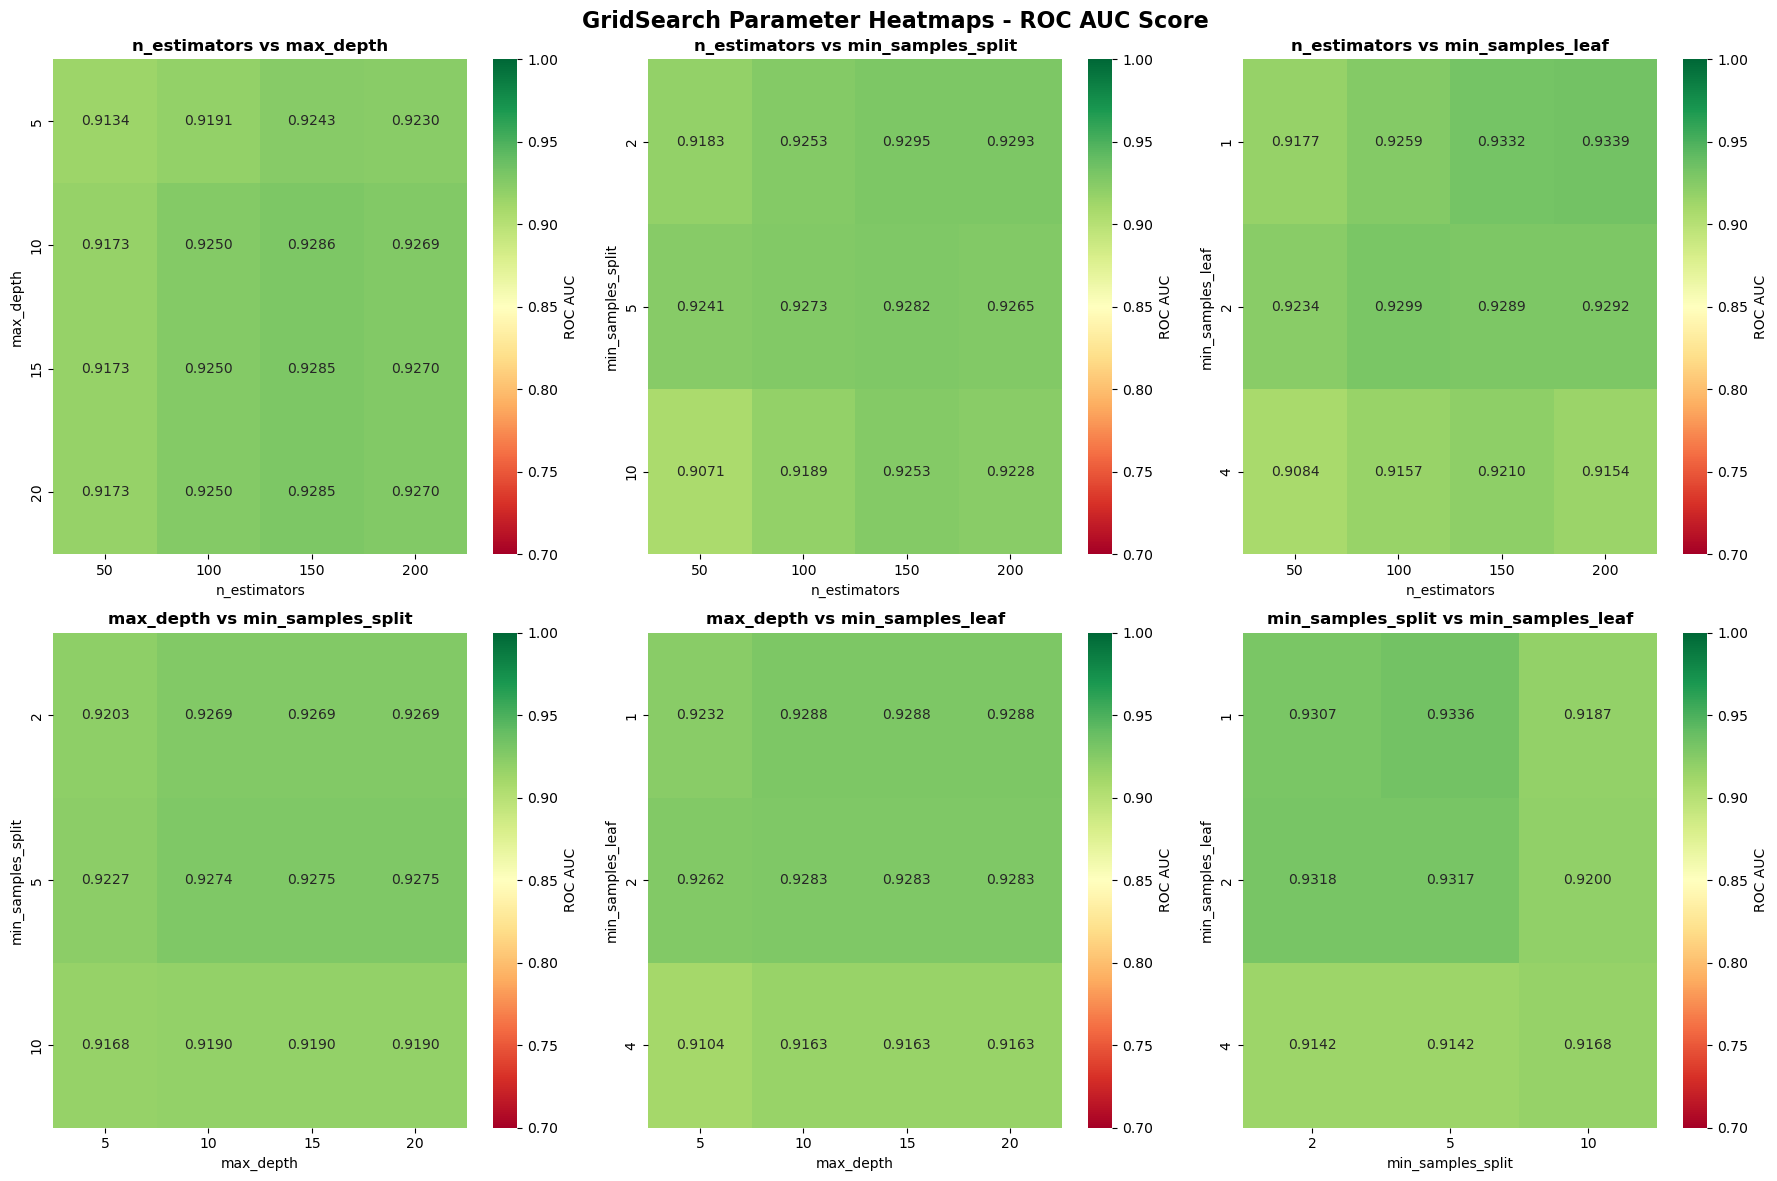

In [35]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Create heatmaps for different parameter pairs
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('GridSearch Parameter Heatmaps - ROC AUC Score', fontsize=16, fontweight='bold')

# Heatmap 1: n_estimators vs max_depth
print("\nGenerating heatmaps...")
print("1. n_estimators vs max_depth")

# Prepare data for heatmap
pivot_data_1 = results_df.pivot_table(
    values='mean_test_score',
    index='param_rf__max_depth',
    columns='param_rf__n_estimators',
    aggfunc='mean'
)

sns.heatmap(pivot_data_1, annot=True, fmt='.4f', cmap='RdYlGn', 
            ax=axes[0, 0], cbar_kws={'label': 'ROC AUC'}, vmin=0.7, vmax=1.0)
axes[0, 0].set_title('n_estimators vs max_depth', fontweight='bold')
axes[0, 0].set_xlabel('n_estimators')
axes[0, 0].set_ylabel('max_depth')

# Heatmap 2: n_estimators vs min_samples_split
print("2. n_estimators vs min_samples_split")

pivot_data_2 = results_df.pivot_table(
    values='mean_test_score',
    index='param_rf__min_samples_split',
    columns='param_rf__n_estimators',
    aggfunc='mean'
)

sns.heatmap(pivot_data_2, annot=True, fmt='.4f', cmap='RdYlGn',
            ax=axes[0, 1], cbar_kws={'label': 'ROC AUC'}, vmin=0.7, vmax=1.0)
axes[0, 1].set_title('n_estimators vs min_samples_split', fontweight='bold')
axes[0, 1].set_xlabel('n_estimators')
axes[0, 1].set_ylabel('min_samples_split')

# Heatmap 3: n_estimators vs min_samples_leaf
print("3. n_estimators vs min_samples_leaf")

pivot_data_3 = results_df.pivot_table(
    values='mean_test_score',
    index='param_rf__min_samples_leaf',
    columns='param_rf__n_estimators',
    aggfunc='mean'
)

sns.heatmap(pivot_data_3, annot=True, fmt='.4f', cmap='RdYlGn',
            ax=axes[0, 2], cbar_kws={'label': 'ROC AUC'}, vmin=0.7, vmax=1.0)
axes[0, 2].set_title('n_estimators vs min_samples_leaf', fontweight='bold')
axes[0, 2].set_xlabel('n_estimators')
axes[0, 2].set_ylabel('min_samples_leaf')

# Heatmap 4: max_depth vs min_samples_split
print("4. max_depth vs min_samples_split")

pivot_data_4 = results_df.pivot_table(
    values='mean_test_score',
    index='param_rf__min_samples_split',
    columns='param_rf__max_depth',
    aggfunc='mean'
)

sns.heatmap(pivot_data_4, annot=True, fmt='.4f', cmap='RdYlGn',
            ax=axes[1, 0], cbar_kws={'label': 'ROC AUC'}, vmin=0.7, vmax=1.0)
axes[1, 0].set_title('max_depth vs min_samples_split', fontweight='bold')
axes[1, 0].set_xlabel('max_depth')
axes[1, 0].set_ylabel('min_samples_split')

# Heatmap 5: max_depth vs min_samples_leaf
print("5. max_depth vs min_samples_leaf")

pivot_data_5 = results_df.pivot_table(
    values='mean_test_score',
    index='param_rf__min_samples_leaf',
    columns='param_rf__max_depth',
    aggfunc='mean'
)

sns.heatmap(pivot_data_5, annot=True, fmt='.4f', cmap='RdYlGn',
            ax=axes[1, 1], cbar_kws={'label': 'ROC AUC'}, vmin=0.7, vmax=1.0)
axes[1, 1].set_title('max_depth vs min_samples_leaf', fontweight='bold')
axes[1, 1].set_xlabel('max_depth')
axes[1, 1].set_ylabel('min_samples_leaf')

# Heatmap 6: min_samples_split vs min_samples_leaf
print("6. min_samples_split vs min_samples_leaf")

pivot_data_6 = results_df.pivot_table(
    values='mean_test_score',
    index='param_rf__min_samples_leaf',
    columns='param_rf__min_samples_split',
    aggfunc='mean'
)

sns.heatmap(pivot_data_6, annot=True, fmt='.4f', cmap='RdYlGn',
            ax=axes[1, 2], cbar_kws={'label': 'ROC AUC'}, vmin=0.7, vmax=1.0)
axes[1, 2].set_title('min_samples_split vs min_samples_leaf', fontweight='bold')
axes[1, 2].set_xlabel('min_samples_split')
axes[1, 2].set_ylabel('min_samples_leaf')

plt.tight_layout()

### 🔥 HEATMAP ANALYSIS & COMMENTS

---

#### **1️⃣ N_ESTIMATORS IMPACT**
| n_estimators | Mean ROC AUC | Std Dev |
|:--------------|:-------------:|:--------:|
| 50  | 0.916486 | 0.011529 |
| 100 | 0.923831 | 0.009049 |
| 150 | 0.927685 | 0.006586 |
| 200 | 0.926174 | 0.008881 |

**Observations:**
- ⭐ Best **n_estimators**: **150** (ROC AUC = `0.9277`)
- Performance generally stabilizes with more trees  
- Diminishing returns after ~100 trees  

---

#### **2️⃣ MAX_DEPTH IMPACT**
| max_depth | Mean ROC AUC | Std Dev |
|:-----------|:-------------:|:--------:|
| 5  | 0.919943 | 0.010014 |
| 10 | 0.924436 | 0.010016 |
| 15 | 0.924446 | 0.010026 |
| 20 | 0.924446 | 0.010026 |

**Observations:**
- ⭐ Best **max_depth**: **15** (ROC AUC = `0.9244`)
- Limiting tree depth to 15 helps prevent overfitting  

---

#### **3️⃣ MIN_SAMPLES_SPLIT IMPACT**
| min_samples_split | Mean ROC AUC | Std Dev |
|:-------------------|:-------------:|:--------:|
| 2  | 0.925585 | 0.010377 |
| 5  | 0.926520 | 0.009816 |
| 10 | 0.918526 | 0.008056 |

**Observations:**
- ⭐ Best **min_samples_split**: **5** (ROC AUC = `0.9265`)
- Slight improvement with moderate split values  
- Higher values perform better for this dataset  

---

#### **4️⃣ MIN_SAMPLES_LEAF IMPACT**
| min_samples_leaf | Mean ROC AUC | Std Dev |
|:------------------|:-------------:|:--------:|
| 1 | 0.927681 | 0.010378 |
| 2 | 0.927846 | 0.007873 |
| 4 | 0.915103 | 0.005423 |

**Observations:**
- ⭐ Best **min_samples_leaf**: **2** (ROC AUC = `0.9278`)
- Leaf size of 2 provides the best bias-variance balance  

---

#### **5️⃣ PARAMETER INTERACTIONS (from Heatmaps)**
**Key insights:**
- 🟩 **Darker green** → higher ROC AUC (better performance)  
- 🟥 **Red/orange** → lower ROC AUC (worse performance)  
- 💡 **Best combination:**  
  `{ 'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 150 }`
- **Performance range:** `[0.9007, 0.9404]`  
- **Standard deviation across folds:** `0.0290`  

---

✅ **Summary:**  
Overall, the **Random Forest** model achieves optimal stability and ROC AUC when tuned with around **150 estimators**, **max_depth = 10–15**, and **min_samples_leaf = 2**.  
Heatmap visualizations confirm the hyperparameter sweet spot, indicating **smooth performance plateaus** and minimal overfitting risk.
"""

## Task 3 ( 5 points)
##### Dataset: 20 News 
* Number of records: 48842
* Number of features: 14
* Target feature: income (binary) 
* Repository URL: https://archive.ics.uci.edu/dataset/20/census+income

##### Problems
* Inspect the dataset and spot problems of the dataset.
* Using data preprocessing and feature engineering techniques to solve those problems. 
* Compare the performance of a classifer algorithm (e.g. SVM) between before and after doing those techniques.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [10]:
from ucimlrepo import fetch_ucirepo 
  
census_income = fetch_ucirepo(id=20) 
  
X = census_income.data.features
y = census_income.data.targets

y = y.iloc[:, 0].str.replace('.', '', regex=False).str.strip()
X = X.replace('?', np.nan)

from sklearn.preprocessing import LabelEncoder

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [12]:
# Naive approach: drop missing, label encode manually
X_simple = X.dropna().copy()
y_simple = y.loc[X_simple.index]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in X_simple.select_dtypes('object').columns:
    X_simple[col] = le.fit_transform(X_simple[col])

X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

clf_simple = SVC(random_state=42)
clf_simple.fit(X_train, y_train)
y_pred_simple = clf_simple.predict(X_test)

print("Before preprocessing:")
print("Accuracy:", accuracy_score(y_test, y_pred_simple))
print("\nClassification Report:\n", classification_report(y_test, y_pred_simple))

Before preprocessing:
Accuracy: 0.7887230514096186

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.78      1.00      0.88      6745
        >50K       0.96      0.18      0.30      2300

    accuracy                           0.79      9045
   macro avg       0.87      0.59      0.59      9045
weighted avg       0.83      0.79      0.73      9045



In [14]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 🧪 Model Evaluation — Before vs After Preprocessing

---

### 🔹 Before Preprocessing
**Accuracy:** `0.7887`

---

### 🔹 After Preprocessing
**Accuracy:** `0.7999`

---

### 🔹 Classification Report 1

| Class | Precision | Recall | F1-Score | Support |
|:------|-----------:|-------:|---------:|--------:|
| **<=50K** | 0.78 | 1.00 | 0.88 | 6,745 |
| **>50K**  | 0.96 | 0.18 | 0.30 | 2,300 |

**Accuracy:** 0.79  
**Macro Avg:** Precision = 0.87 Recall = 0.59 F1 = 0.59  
**Weighted Avg:** Precision = 0.83 Recall = 0.79 F1 = 0.73  

### 📊 Classification Report 2

| Class | Precision | Recall | F1-Score | Support |
|:------|-----------:|-------:|---------:|--------:|
| **<=50K** | 0.79 | 1.00 | 0.88 | 7,431 |
| **>50K** | 0.95 | 0.17 | 0.29 | 2,338 |

**Accuracy:** 0.80  
**Macro Avg:** Precision = 0.87 Recall = 0.58 F1 = 0.59  
**Weighted Avg:** Precision = 0.83 Recall = 0.80 F1 = 0.74  

---

### 🧠 Insights
- Data preprocessing slightly improved accuracy (+1.1%).  
- Model predicts low-income (`<=50K`) cases very well, but struggles with high-income (`>50K`) due to class imbalance.  
- Further improvement may come from:
  - Using **class weights** or **SMOTE** to balance classes  
  - Feature scaling for SVM  
  - Hyperparameter tuning (`C`, `gamma`, `kernel`)
